# Building segmentation

## Background

This notebook describes the ongoing development of a convolutional neural network (CNN) that identifies village-features in satellite images. **This notebook uses only two of 29 total image rasters -- in other words, the dataset is smaller.** The Building_Segmentation notebook, in contrast, shows the CNN model trained on the full dataset, which cannot be uploaded to Github due to its size. This notebook uses a small subset of the total training data that can be uploaded to Github, allowing the user to reproduce the results that I show. Though this notebook is intended as a stand-alone demonstration of machine vision, this work is a part of a larger project that seeks to predict the risk of disease spillover from wildlife into humans. 

As a postdoc at the University of Idaho, I develop computational pipelines that forecast the spread of viruses from wildlife into humans. Oftentimes, these zoonotic viruses occur in areas with limited health infrastructure. As a result, the extent of the risk of these viruses is often underestimated or unknown. My current work focuses on Lassa virus, an arenavirus that circulates within rodent populations in West Africa and transmits to humans that come into contact with rodent waste. Building better forecasts requires environmental features that describe the abundance of rodents that host the virus. Past field surveys have indicated that rodent populations are more prevalent in areas with houses near agricultural cultivations, for example, and less prevalent in forested areas of the village. Consequently, CNN's that extract features like houses, cultivations, forest, etc, from imagery, could provide a feature-set that allows for finescale risk prediction. 

As a first step towards this goal, I have worked on a CNN that identifies buildings in satellite imagery. Specifically, this CNN will classify buildings as traditional hut (circular thatch structure), modern building (rectangular aluminum roof), and background. 

## Set up the working environment

In [1]:
# Libraries for working with directories
import os
import shutil

# Libraries for dataframes and arrays
import numpy as np
import pandas as pd

# Libraries for plotting
from matplotlib import pyplot as plt
import matplotlib as mpl

# Image manipulation libraries
import skimage.io as io
import cv2
import skimage 
import skimage.transform

# Modules that work with shapefiles and rasters
import rasterio
from rasterio import features
from rasterio.mask import mask
import fiona

import imgaug.augmenters as iaa

# Tensorflow modules for building the CNN
from tensorflow.python.keras.applications.efficientnet import *
from tensorflow.keras.layers import UpSampling2D, concatenate, Input, Conv2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K ## Functions for sum, square, abs of tensors

In [2]:
# Helps Jupyter notebook quickly load auto-completion suggestions
%config Completer.use_jedi = False

## Describe the dataset

The dataset for this project was created in QGIS and consists of 
- 1. A shapefile that contains polygon features that describe building outlines within 29 village locations

- 2. 29 village-wide satellite images saved as TIF rasters   

The shapefile is saved in Data/Shapefiles/ directory, while the TIF rasters are saved in Data/Raster_Images/ directory. As stated before, any pixel within the TIF images can be 1) background, 2) modern building, or 3) traditional building (thatched hut). We'll create a dictionary that associates each of these different feature-types with a number. In addition, define a color-map that will ensure that any images that are plotted show up consistently throughout this notebook.  

In [3]:
# Set up color scheme and feature dictionary
feature_dict = {'0': 'background', '1':'modern_build', '2':'trad_build'}
colors = ['yellow', 'red', 'blue']
cmap = mpl.colors.ListedColormap(colors)

## Load in helper functions

These are functions created by me to streamline various tasks. I'll point out when these are used throughout this notebook. 

In [4]:
exec(open("Tools/Misc_Funs.py").read()) #test

In [ ]:
seq = iaa.Sequential([iaa.ChannelShuffle(0.25),
                      iaa.GaussianBlur(0,3),
                      iaa.Crop(px=(0,10)),#, keep_size = True), 
                      iaa.Rotate(rotate = (-180,180), mode = 'reflect'), 
                      iaa.MultiplyAndAddToBrightness(mul=(0.8, 1.2), add=(-15, 15))])

## Create annotated TIFs from satellite images and shapefile

The next cell creates annotated labels for the polygon features (i.e., buildings) that fall into each TIF image. In GIS terms, this often called burning the polygon features into a raster. 

In [5]:
# Load up to date version of shapefile
landcover_shp = fiona.open("Data/Shapefiles/Features.shp", "r")

##image_list = ['Bantou.tif', 'Tanganya.tif']
image_list = os.listdir('Data/Raster_Images')

for raster_name in image_list:
    # Load base-raster / image
    with rasterio.open('Data/Raster_Images/' + raster_name) as src:
        ras_meta = src.profile
        org_data = src.read()
        img_shape = src.shape
        transform = src.transform

    image_data = org_data.copy()
    # Loop through landcover features and burn each into label_image data
    label_image = np.zeros((1, img_shape[0], img_shape[1]))

    for val in range(len(feature_dict)):
        feature_name = feature_dict[str(val)]
        geoms = [feature["geometry"] for feature in landcover_shp if (feature['properties']['Type']==val)]
        if len(geoms) > 0:
            out_mask = features.rasterize(geoms, out_shape = img_shape, transform = transform)
            if out_mask.sum():
                label_image[:,out_mask==1] = val + 1

    label_meta = ras_meta
    label_meta.update(compress = 'deflate', predictor = 2, count = 1, nodata = 255)
    with rasterio.open('Data/Raster_Labels/' + raster_name, 'w', **label_meta) as dst:
        dst.write(label_image)
    print('Finished ' + raster_name)

Finished Makuna.tif
Finished Badala.tif
Finished Kanipo.tif
Finished Jimmy.tif
Finished Gbetaya_3.tif
Finished Bafodia.tif
Finished Chembu.tif
Finished Barlie.tif
Finished Makump.tif
Finished Gbetaya_2.tif
Finished Ngegbeima.tif
Finished Gbetaya.tif
Finished Benduma.tif
Finished Njaguima.tif
Finished Kobadu.tif
Finished Ngaiagoehun.tif
Finished Gbenikoro.tif
Finished Tanganya.tif
Finished Malambay.tif
Finished North_Tanganya.tif
Finished Guala.tif
Finished West_Bantou_1.tif
Finished Largo.tif
Finished Gbetaya_1.tif
Finished Mid_Tanganya_Bantou.tif
Finished Kapethe.tif
Finished Talama.tif
Finished Bantou.tif
Finished Taima.tif


## Example image and annotation

Plot an example of the original TIF image (now saved as a cropped PNG) and the corresponding label. The labeled classes are described by the feature_dict: 0 corresponds to background, 1 to modern building, 2 to circular hut. 

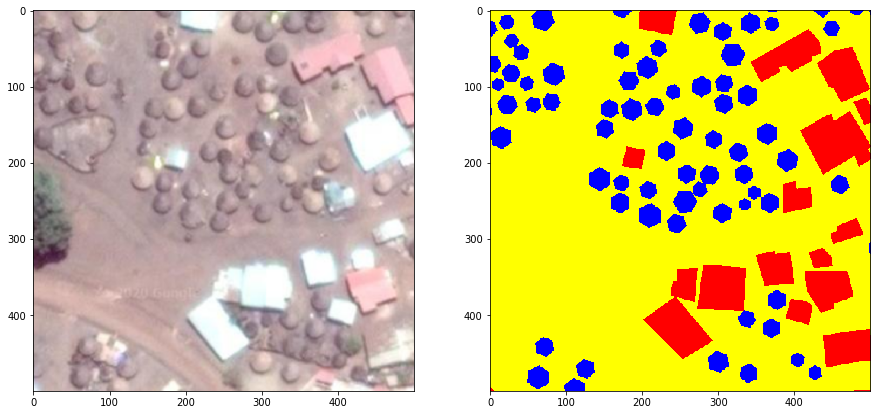

In [6]:
raster_name = 'Bantou.tif'
with rasterio.open('Data/Raster_Images/' + raster_name) as src:
    image_data = src.read()
with rasterio.open('Data/Raster_Labels/' + raster_name) as src:
    label_data = src.read()
    
fig, ax = plt.subplots(1,2, figsize = (15,15))
ax[0].imshow(np.moveaxis(image_data[0:3,1000:1500,3000:3500], 0, -1))
ax[1].imshow(label_data[0,1000:1500,3000:3500], cmap = cmap, interpolation = 'none')
fig.show()

## Create dataset of cropped images

The above images and labels are essentially all that are needed to train the CNN. However, the dimensions of these images is too large to simply plug into a CNN. To help reduce the computational power needed to train the model, the next cell will systematically crop each TIF image (and corresponding label) into workable row x column dimensions. I'll use 512 x 512.  

In addition to cropping the images and labels, the cell also stores information on what features are contained in each image. Each row of full_dataframe contains the image and label names given to the cropped image, the number of pixels of each type in that cropped image, and finally, the number of buildings of each type in that image. 

I use two of my own functions (in Tools/Misc_Funs.py) to help with these tasks. Cropping is performed using my function Crop_Image, while counting buildings is performed using the functions Get_Label_Features and Summarize_Features. 

Get_Label_Features uses opencv to create contours of each building in each cropped image annotation (essentially grouping the pixels of each building into a blob). Summarize_Features counts up the number of each building type. 

In [7]:
imgsize = 512
step = imgsize
image_path = 'Data/Raster_Images/'
label_path = 'Data/Raster_Labels/'
#image_list = os.listdir(image_path)
image_list = ['Bantou.tif', 'Tanganya.tif']

# Storage location of cropped images
name = 'SMALL_imgsize_' + str(imgsize) + '_step_' + str(step)

save_path = 'Data/Cropped_Image_Datasets/'
data_save_path = save_path + name
image_save_path = data_save_path + '/image/'
label_save_path = data_save_path + '/label/'

# Remove any old instance of this dataset, if it exists
try: 
    shutil.rmtree(data_save_path)
except OSError as error: 
    print(error)
try: 
    os.mkdir(data_save_path)
except OSError as error: 
    print(error)     
try: 
    os.mkdir(image_save_path)
except OSError as error: 
    print(error) 
try: 
    os.mkdir(label_save_path)
except OSError as error: 
    print(error)  

count = 0

full_dataframe = pd.DataFrame() #pd.DataFrame({'Image':[], 'Label':[], 'Village':[]})

for image_name in image_list:
    img = io.imread(image_path + image_name)[:,:,0:3]
    label = io.imread(label_path + image_name)
    label = label[:,:,np.newaxis]

    label = label.astype('uint8')
    img = img.astype('uint8')
    image_shape = img.shape

    # Loop through the large images and crop to window
    for x in range(0,image_shape[1]-imgsize, step):
        for y in range(0,image_shape[0]-imgsize, step):
            img_crop, label_crop = Crop_Image(img, label, x, y, imgsize, imgsize)
            ## Save crop to file
            full_image_name = image_save_path + str(count) + '.png'
            full_label_name = label_save_path + str(count) + '.png'
            cv2.imwrite(full_image_name, img_crop)
            cv2.imwrite(full_label_name, label_crop)
            new_data_row = pd.DataFrame({'Image':[full_image_name], 'Label':[full_label_name], 
                                        'Village':[image_name.replace('.tif', '')]})
            for val in range(len(feature_dict)):
                new_data_row[feature_dict[str(val)]] = (label_crop==val).sum()    
                
                
            full_features = Get_Label_Features(label_crop[:,:,0], feature_dict)[1]    
            summ_features = Summarize_Features(full_features)
            new_data_row = pd.concat([pd.DataFrame(new_data_row, index = [0]).reset_index(drop=True), 
                                      summ_features], axis = 1)
            full_dataframe = full_dataframe.append(new_data_row, ignore_index = True)
            count = count + 1
    print('Finished: ' + image_name)
full_dataframe.to_csv(data_save_path + '/' + 'dataframe.csv')

print('Created dataset' + name + ' with ' + str(count) + ' images')

Finished: Bantou.tif
Finished: Tanganya.tif
Created datasetSMALL_imgsize_512_step_512 with 120 images


# Choose test, train and validation sets

I'll use sub-dataframes of full_dataframe to describe the locations and features of test, train, and validation datasets. I'll set aside a single village for testing. Data from this village will not influence the training of the model in any way. 

The model will be trained on train_dataframe data. Validation data (in val_dataframe) will be used to determine the model's performance.  

In [8]:
test_village = 'Bantou'
mask_test = full_dataframe.Village==test_village
test_dataframe = full_dataframe[mask_test].copy()
test_dataframe = test_dataframe.reset_index()

train_val_dataframe = full_dataframe[~mask_test].copy()
train_val_dataframe = train_val_dataframe.reset_index()

np.random.seed(0)
val_prop = 0.2
val = np.random.choice(train_val_dataframe.shape[0], size = round(val_prop*train_val_dataframe.shape[0]))
val_mask = train_val_dataframe.index.isin(val)
val_dataframe = train_val_dataframe[val_mask].copy()
train_dataframe = train_val_dataframe[~val_mask].copy()

## Address class imbalance

The cells below show that background pixels are much more abundant than pixels that are classified as buildings. Furthermore, modern buildings are much more prevalent than traditional buildings. This class imbalance will result in a model that differentiates between background and modern buildings, but misses traditional buildings. 

### Image counts

In [9]:
img_class_freqs = (train_val_dataframe[feature_dict.values()] > 0).sum(axis = 0)
img_class_freqs

background      48
modern_build    20
trad_build      22
dtype: int64

### Pixel counts

In [10]:
pixel_class_freqs = (train_val_dataframe[feature_dict.values()]).sum(axis = 0)
pixel_class_freqs

background      12170602
modern_build      243632
trad_build        168678
dtype: int64

## Resample cropped images by feature type

I'll correct class imbalance in two ways: first, I'll resample the training and validation datasets so that images that contain pixels labeled as background, modern building, and traditional building are present in equal proportions; secondly, I'll use a loss function based on the Dice coefficient that (for each image) weights each feature type equally. 

Resampling the data in a balanced way (1 above) is a bit challenging because feature types are correlated: an image with a modern building is more likely to contain images with a traditional building as well. To achieve a more equal balance of images with each pixel-type, we'll iteratively add images to a dataframe. At each iteration, the function below adds an image containing the feature-type that is least represented in the current dataframe. 

When by_pixels is False, an image is considered to "contain the feature" when the number of pixels of a feature-type is greater than the corresponding entry in thresh_list (order is defined by feature_dict). Preliminary work indicated that model performance suffered when few true background images (i.e., images that contained no buildings of either type) were not included in the dataset. As a result, I set the pixel-threshhold corresponding to the background class to be 0.99*imgsize^2, meaning that the image is only called background when it contains almost no buildings.  

In [11]:
def resample_dataframe(df, feature_dict, thresh_list, by_pixels = False, nsamps = 1):
    resample_df = df.iloc[0:nsamps].copy()
    cur_size = resample_df.shape[0]

    while cur_size < df.shape[0]: 
        if by_pixels==True:
            current_nums = (resample_df[feature_dict.values()]).sum(axis = 0)
        else:
            current_nums = (resample_df[feature_dict.values()] > thresh_list).sum(axis = 0)    
        current_nums = current_nums/current_nums.sum()
        get_group = current_nums.argmin()
        get_mask = df[feature_dict[str(get_group)]] > thresh_list[get_group]
        get_df = df.loc[get_mask,:]
        new_samps = get_df.sample(n = nsamps, replace = True)
        resample_df = pd.concat((resample_df, new_samps), axis = 0)
        cur_size = resample_df.shape[0]
    
    print(current_nums)    
    return resample_df.copy()

In [12]:
train_dataframe = resample_dataframe(df = train_dataframe, feature_dict = feature_dict, 
                                     thresh_list = np.array([0.99*imgsize**2, 0,0]))

background      0.333333
modern_build    0.317460
trad_build      0.349206
dtype: float64


In [13]:
val_dataframe = resample_dataframe(df = val_dataframe, feature_dict = feature_dict, 
                                     thresh_list = np.array([0.99*imgsize**2, 0,0]))

background      0.307692
modern_build    0.307692
trad_build      0.384615
dtype: float64


## Build a CNN using U-Net archictexture

In the following, I define the CNN model that will perform image segmentation. The CNN is based around the [U-Net design](https://link.springer.com/chapter/10.1007%2F978-3-319-24574-4_28) that performs well on image segmentation tasks. The U-Net design is composed of an encoder that, generally speaking, reorganizes and aggregates the image-information in a (hopefully) meaningful way, and a decoder that uses the aggregated output of the encoder to assign classes to each pixel.  

There are many pre-built CNN choices for the encoder. I'll use the [EfficientNet](https://arxiv.org/abs/1905.11946), which rivals the performance of the best ResNet's on the imagenet dataset while using many fewer parameters. The Model_Frames code also contains an implementation of VGG16 -- this CNN performs well also, but uses ~10 times as many parameters as EfficientNet! EfficientNets vary in complexity from "size" 0 (the simplest) to 7. This parameter is defined as bval, which I'll choose as 0 for this notebook. 

The model framework is defined as a function in the Model_Frames directory. The eff_unet function takes on different hyperparameter inputs (such as whether or not to use batch normalization, input size, etc.), and returns a compiled model. 

Once compiled, the model is trained for 500 epochs Throughout the training process, the model weights are saved whenever the dice loss evaluated on the validation dataset is lower (i.e., better) than the model's current best performance. Model weights are saved to the Fitted_Model_Weights directory. Finally, the model performance is tracked in a log file located in Fitted_Models/logs directory. A user-defined model prefix, as well as hyperparameters used to fit the model, are incorporated into a model_name that identifies the weights and log csv file. 

Of course, a typical user would want to compare the validation loss on different hyperparameter choices. I don't do this here because I want to keep this notebook simple. Instead, I'm going to assign hyperparameters to values that performed well in my own personal investigations. The reader will note, however, that the code is structured to easily allow comparison between CNNs with different hyperparameters. 

In [14]:
prefix = 'small_unet_boot'
tarsize = imgsize
loss = 'dice'
lrb10 = 3
bval = 0
epochs = 500
batch_size = 16
dropout = 0.0
bn = True
rot = 0
zo = 0
load_model = False
lr = 10**(-lrb10)

model_name = (prefix + 
                '_bs' + str(batch_size) + '_lr' + str(lrb10) + '_lo' +
                loss + '_ro' + str(rot) + '_zo' + str(zo) + '_bn' + 
                  str(1*bn) + '_tp' + str(1-val_prop) + 
                '_crop' + str(imgsize) + '_tar' + str(tarsize))

exec(open("./Model_Frames/model_eff_unet.py").read())

nfeatures = len(feature_dict)

model = eff_unet(BVal = bval, input_size = (tarsize, tarsize,3), dropout = dropout, 
        batch_norm = bn, fix_weights = False, loss = loss, lr = lr, 
        num_class = len(feature_dict))

if load_model:
    model.load_weights("Models/" + model_name + ".hdf5")


We'll use data generators to feed image data into the model during training. I'll only use horizontal and vertical flips for data augmentation, as rotation and zoom can lead to unwated interpolation of annotated images. The EfficientNet framework that I use normalizes the images as a first step; consequently, we do not need to normalize image outputs from the generators. If, instead, the VGG16 model frame is used, the normalization must occur within the generator (set normalize = True). 

In [15]:
model_checkpoint = ModelCheckpoint("Fitted_Models/" + model_name + ".hdf5", monitor='val_loss',verbose=1, save_best_only=True)
csv_checkpoint = CSVLogger("Fitted_Models/logs/" + model_name + ".csv", separator = ',', append = load_model)    
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min')
num_train_img = train_dataframe.shape[0]
num_val_img = val_dataframe.shape[0]
train_steps = num_train_img // batch_size
target_size = (tarsize, tarsize)
val_steps = num_val_img // np.min([batch_size, val_dataframe.shape[0]])

train_generator = Image_Generator(train_dataframe, rot = rot, 
                                    batch_size = batch_size,
                                    image_color_mode = "rgb", 
                                    mask_color_mode = "grayscale",
                                    feature_dict = feature_dict, 
                                    target_size = target_size, 
                                    zoom_range = zo,
                                    fill_mode = 'reflect',
                                    horizontal_flip=True, 
                                    vertical_flip=True,
                                 normalize = False)    
val_generator = Image_Generator(val_dataframe, rot = 0, 
                                    batch_size = np.min([batch_size, val_dataframe.shape[0]]),
                                    image_color_mode = "rgb", 
                                    mask_color_mode = "grayscale",
                                    feature_dict = feature_dict, 
                                    target_size = target_size, 
                                    zoom_range = 0, 
                                    horizontal_flip = False,
                                    vertical_flip = False,
                                 normalize = False)      



Here's an example of the train_generator in action. 

Found 39 validated image filenames.
Found 39 validated image filenames.


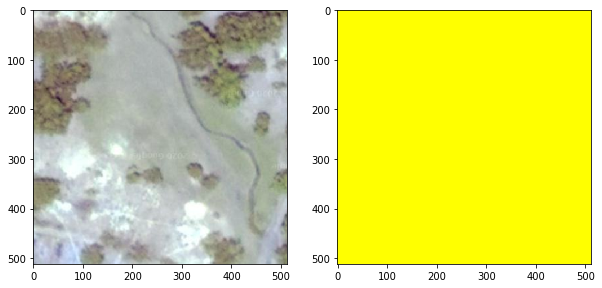

In [16]:
np.random.seed(1)
im, la = next(train_generator)
la = la[0,:,:,:]
la = la.argmax(-1)
f, ax = plt.subplots(1,2,figsize = (10,20))
ax[0].imshow(im[0,:,:,:].astype('uint8'), cmap = cmap, interpolation = 'none')
ax[1].imshow(la[:,:], cmap = cmap)

At long last, we fit the CNN!

In [17]:
history = model.fit(train_generator,steps_per_epoch= train_steps, epochs=epochs,
                    callbacks=[model_checkpoint, csv_checkpoint],
                    validation_data = val_generator, validation_steps = val_steps)

Epoch 1/500
2/2 [==============================] - ETA: 0s - loss: -0.5651 - categorical_accuracy: 0.2949 - Dice_Coef_Multilabel: -0.5814 - categorical_crossentropy: 1.5880Found 9 validated image filenames.
Found 9 validated image filenames.

Epoch 00001: val_loss improved from inf to -0.71754, saving model to Fitted_Models/small_unet_boot_bs16_lr3_lodice_ro0_zo0_bn1_tp0.8_crop512_tar512.hdf5
2/2 [==============================] - 7s 4s/step - loss: -0.5651 - categorical_accuracy: 0.2949 - Dice_Coef_Multilabel: -0.5814 - categorical_crossentropy: 1.5880 - val_loss: -0.7175 - val_categorical_accuracy: 0.7375 - val_Dice_Coef_Multilabel: -0.7175 - val_categorical_crossentropy: 0.7740
Epoch 2/500
2/2 [==============================] - ETA: 0s - loss: -0.5737 - categorical_accuracy: 0.3259 - Dice_Coef_Multilabel: -0.5737 - categorical_crossentropy: 1.5850
Epoch 00002: val_loss did not improve from -0.71754
2/2 [==============================] - 2s 797ms/step - loss: -0.5737 - categorical_ac

Load the log csv file and evaluate the validation loss metric. 

Model 1:-2.61


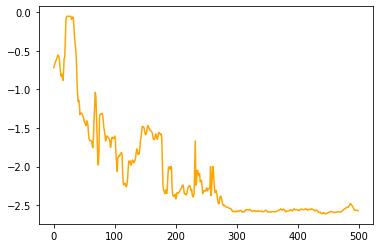

In [18]:
metric = 'val_Dice_Coef_Multilabel'
compare_list = [model_name]
cols = ['blue', 'orange', 'red', 'green', 'black']
for alt in range(len(compare_list)):
    name = compare_list[alt]
    log = pd.read_csv('Fitted_Models/logs/' + name +  '.csv')
    print('Model ' + str(1 + alt) + ':' +  str(np.round(log[metric].min(), 2)))
    plt.plot(log[metric], color = cols[1 + alt])


plt.show()

## Evaluate best model on test village

The Keras checkpoint module only saves the model weights if they have achieved the best validation loss. In the following cell I load these weights. 

In [19]:
model_name = 'small_unet_boot_bs16_lr3_lodice_ro0_zo0_bn1_tp0.8_crop512_tar512'
model.load_weights("Fitted_Models/" + model_name + ".hdf5")

Define a function that loads in a large TIF image (data-format prior to cropping), and applies the CNN to each 512 x 512 subimage within the larger TIF image. For each pixel, we can allow the ultimate prediction to be computed from the average of multiple predictions that are created when sliding the CNN window over the image. This is achieved by choosing "step" to be less than the CNN input size (512, in this notebook). Finally, rescale can be assigned a value different than one if the target size (output image size of the image generator) was smaller than the cropped image size. In this case, the image resolution seen by the CNN is lower than that prepared in the cropping step. No such rescaling took place in this notebook, so rescale is set to 1. The function returns the original image data, probabilities for each pixel being a member of each class, and a flattened annotated image label. 

I'll apply this plot_pred function to the test village Bantou. **Importantly, the CNN has not seen this data!!!** After plotting the prediction on the large image file, I'll show 2 more examples with increasing level of zoom. 

In [20]:
def plot_pred(image_name, cnn, step = 32, rescale = 1, path = 'Data/Raster_Images/', cmap = None):
    """ Generate a plot comparison of original image and segmented image"""
    img = io.imread(path + image_name)
    reimg = np.round(255*skimage.transform.rescale(img, (rescale, rescale, 1))).astype(np.uint8)

    c_array = reimg[:,:,0:3]
    prediction, class_prediction = Predict_Class_Probabilities(array = c_array, model = cnn, 
                                    step = step)
    f, ax = plt.subplots(1,2, figsize = (20, 20))
    ax[0].imshow(img)
    ax[1].imshow(class_prediction, interpolation='none', cmap=cmap)

    return(c_array, prediction, class_prediction)

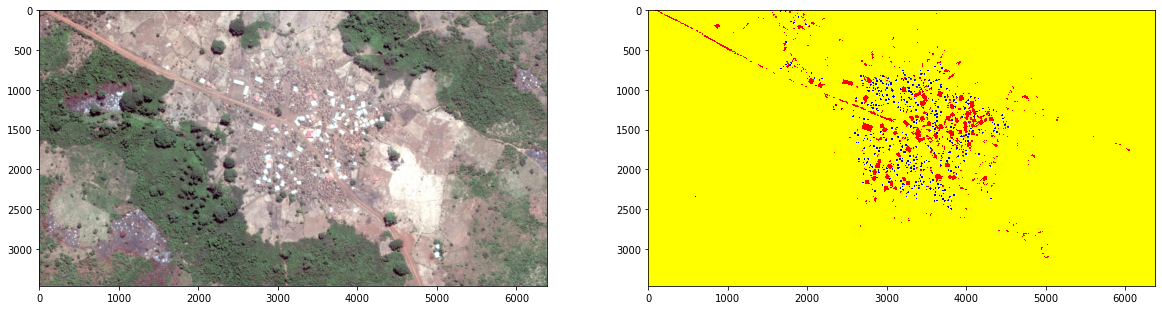

In [21]:
image_array, cnn_prediction, predicted_class = plot_pred(image_name = 'Bantou.tif', cnn = model, 
                                                         step = 128, rescale = tarsize/imgsize, 
          path = 'Data/Raster_Images/', cmap = cmap)

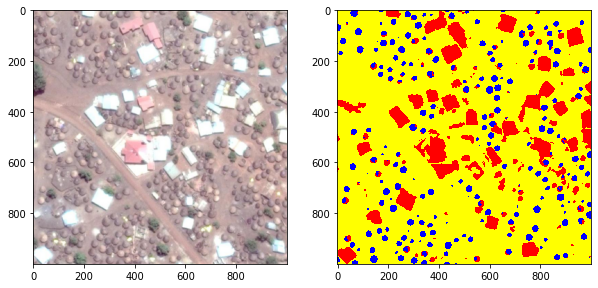

In [22]:
row = 1000
col = 3000
size = 1000
image_crop = image_array[row:(row + size), col:(col + size), :]
pred_class_crop = predicted_class[row:(row + size), col:(col + size)]
f, ax = plt.subplots(1,2, figsize = (10, 20))
ax[0].imshow(image_crop)
ax[1].imshow(pred_class_crop, interpolation='none', cmap=cmap)
f.savefig('Figures/CNN_Segmentation_Performance_1.png', 
         bbox_inches='tight', transparent="True", pad_inches=0)

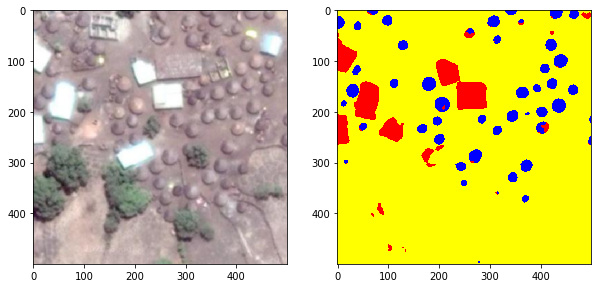

In [23]:
row = 2000
col = 3000
size = 500
image_crop = image_array[row:(row + size), col:(col + size), :]
pred_class_crop = predicted_class[row:(row + size), col:(col + size)]
f, ax = plt.subplots(1,2, figsize = (10, 20))
ax[0].imshow(image_crop)
ax[1].imshow(pred_class_crop, interpolation='none', cmap=cmap)
f.savefig('Figures/CNN_Segmentation_Performance_2.png', 
         bbox_inches='tight', transparent="True", pad_inches=0)

Even on this smallish dataset, it appears that the CNN is performing well on the test data. Currently, the model predictions are pixel-based, meaning that there is nothing in the prediction that groups pixels into individual buildings. I'll use tools from openCV to achieve this. Specifically, I'll extract image contours from the model predictions using openCV's FindContours function. Each contour returned by this function is a list of coordinates that describe a single building. This, in turn, can be used to count the number of buildings of each type. 

I wrote a function called Predict_Image_Contours (located in Tools/Misc_Funs.py) that uses these extracted contours to overlay circles and rectangles onto the original image. Most of the work of this function is done by the openCV FindContours function. The function returns the original image with overlayed contours, colored by building type. Clearly, the contour approach has trouble identifying adjacent buildings as unique. 

In [24]:
expanded_pred_crop = Expand_Mask(pred_class_crop, feature_dict)
img_with_contours = Predict_Image_Contours(img = image_crop/255.0, mask_full = expanded_pred_crop, 
                       feature_dict = feature_dict, filename = None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


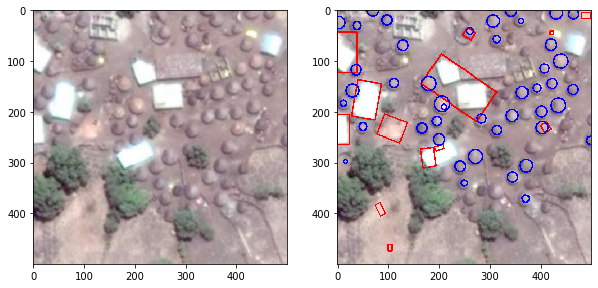

In [25]:
f, ax = plt.subplots(1,2, figsize = (10, 20))
ax[0].imshow(image_crop)
ax[1].imshow(img_with_contours, interpolation='none', cmap=cmap)
f.savefig('Figures/Small_CNN_Contour_Performance.png', 
         bbox_inches='tight', transparent="True", pad_inches=0)

I'll check the model performance in two ways: first, I'll calculate the dice loss of model predictions on images from Bantou; second, I'll evaluate the model's ability to count the number of each building type in Bantou. In the cell below, I loop through each cropped image from the test village Bantou, use the CNN to segment the image and count each building type, evaluate the model predictions using the metrics used during training, and store all of this information into a dataframe test_eval_df. Specifically, each row of test_eval_df describes the model's performance on a single image of Bantou test data. 

The columns that are most interesting are true counts of modern and traditional buildings in the image (true_nmod, true_ntrad), predicted building counts (pred_nmod, pred_ntrad), dice loss (loss) and accuracy (categorical_accuracy). 

In [26]:
eval_ls = list()

for ii in range(test_dataframe.shape[0]):
    im_name = test_dataframe.Image[ii]
    la_name = test_dataframe.Label[ii]

    # Read image and label
    im = io.imread(im_name)
    im = im[np.newaxis, :, :, :]  
    
    la = io.imread(la_name)
    la = la[np.newaxis, :, :]
    la = Expand_Mask(la, feature_dict)

    nback = la[0,:,:,0].sum()
    nmod = la[0,:,:,1].sum()
    ntrad = la[0,:,:,2].sum()
    
    true_mod_num = test_dataframe.nModBuild[ii]
    true_trad_num = test_dataframe.nTradBuild[ii]
    
    pred_la = model.predict(im)
    pred_la = pred_la.argmax(axis = -1)
    pred_la_expand = Expand_Mask(pred_la, feature_dict)
    
    full_features = Get_Label_Features(pred_la[0,:,:], feature_dict)[1]    
    summ_features = Summarize_Features(full_features)
    
    
    pred_mod_num = summ_features.nModBuild.values[0]
    pred_trad_num = summ_features.nTradBuild.values[0]
    
    
    
    metrics = model.evaluate(im, la);
    
    metrics.insert(0,ii)
    metrics += [im_name, la_name, nback, nmod, ntrad, true_mod_num, pred_mod_num, true_trad_num, pred_trad_num]
    eval_ls.append(metrics)

    
test_eval_df = pd.DataFrame(eval_ls, columns = ['ii', 'loss', 'cat_acc', 'dice', 'cross', 'Image', 'Label', 
                                                 'background', 'modern_build', 'trad_build',
                                                'true_nmod', 'pred_nmod', 'true_ntrad', 'pred_ntrad'])



1/1 [==============================] - 0s 1ms/step - loss: -0.9980 - categorical_accuracy: 0.9961 - Dice_Coef_Multilabel: -0.9980 - categorical_crossentropy: 0.0629


Next, evaluate the overall mean dice loss on the test village. 

In [27]:
test_eval_df.loss.mean()

-1.3092072076267667

Initially, I was somewhat shocked that the loss column showed relatively weak model performance (e.g., dice scores around -1, where a perfect score is -3). These poor loss scores occur in images that are pure background -- in these cases, if the model assigns any nonzero probability of a pixel being a building, it receives a dice score of 0 for that feature. A -1 is a perfect score for that feature, so that perfect segmentation of all 3 features gives the best score of -3. In contrast, accuracy shows the model's performance is excellent when predictions are coded into discrete classes. The discrepancy in these two measures is due to that fact that even if our model classifies some pixels as building with low probability, it will be severely penalized when it is assessed with the dice coefficient.   

These low scores were much less common in the training stage because I resampled images. The resampled dataset contained relatively fewer pure background images. If, instead, I only evaluate the dice loss on images with at least one building pixel, the mean dice score improves to a level that is in-line with the validation metrics:

In [28]:
test_eval_df[(test_eval_df.true_nmod > 0) | (test_eval_df.true_ntrad > 0)].loss.mean()

-2.0651618469329107

Next, evaluate the model's ability to count different building types in an image. 

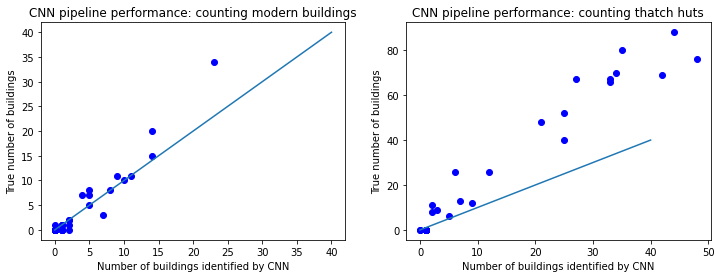

In [31]:
f, ax = plt.subplots(1,2,figsize = (12,4))

ax[0].plot(test_eval_df.pred_nmod, test_eval_df.true_nmod, 'bo')
ax[0].plot([0,40],[0,40])
ax[0].title.set_text('CNN pipeline performance: counting modern buildings')
ax[0].set_xlabel('Number of buildings identified by CNN')
ax[0].set_ylabel('True number of buildings')
ax[1].plot(test_eval_df.pred_ntrad, test_eval_df.true_ntrad, 'bo')
ax[1].plot([0,40],[0,40])
ax[1].title.set_text('CNN pipeline performance: counting thatch huts')
ax[1].set_xlabel('Number of buildings identified by CNN')
ax[1].set_ylabel('True number of buildings')
f.savefig('Figures/Small_CNN_Building_Counts.png', 
         bbox_inches='tight', transparent="True", pad_inches=0)


Overall, the CNN demonstrates an ability to identify and count different types of buildings in satellite imagery. However, the CNN pipeline also tends to underestimate the number of both types of buildings in densely packed areas. This underestimation is less severe when the CNN is trained on the full dataset (see Building_Segmentation notebook). This is almost certainly due to the methods used to group pixels into buildings. Namely, if two or more buildings are touching or close together in an image, the CNN will segment them into a single object without space between the buildings. In turn, the FindContours method will interpret this group of pixels as a single building instead of multiple buildings. 

## Future directions

Overall, the CNN pipeline demonstrated a clear ability to segment and count buildings in West African imagery. These building counts, in turn, could be used to better understand the relative risk that Lassa-infected rodents pose to humans. Traditional thatch huts, for example, may be more permiable to rodents than modern buildings that are built with concrete and aluminum. As part of ongoing work, I'm using these extracted features as predictors in another model that is paired with village-level data on Lassa prevalence in rodents and rodent abundance. 

This work can be extended in several ways. Most obviously, additional village-features, such as trees and agriculture, could be added into the dataset. Throughout this work, I've tried hard to write code that will allow these additional feature-types to be easily added into the training process. 

Another addition that I plan to explore is a more careful algorithm for grouping pixels into buildings. Different image processing algorithms like opening, closing, and watershed transforms can oftentimes be used to better distinguish image-features that are close to each other in the image [example](https://docs.opencv.org/4.5.2/d3/db4/tutorial_py_watershed.html). 